<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>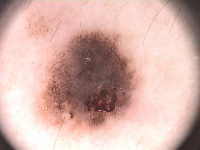</td><td>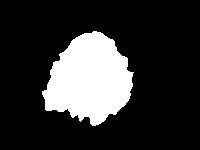</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
images = []
lesions = []
import os

from skimage.io import imread
root = 'ph2dataset/PH2Dataset/'

for root, dirs, files in os.walk('/kaggle/input/ph2dataset/PH2Dataset/PH2_Dataset/'):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [4]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

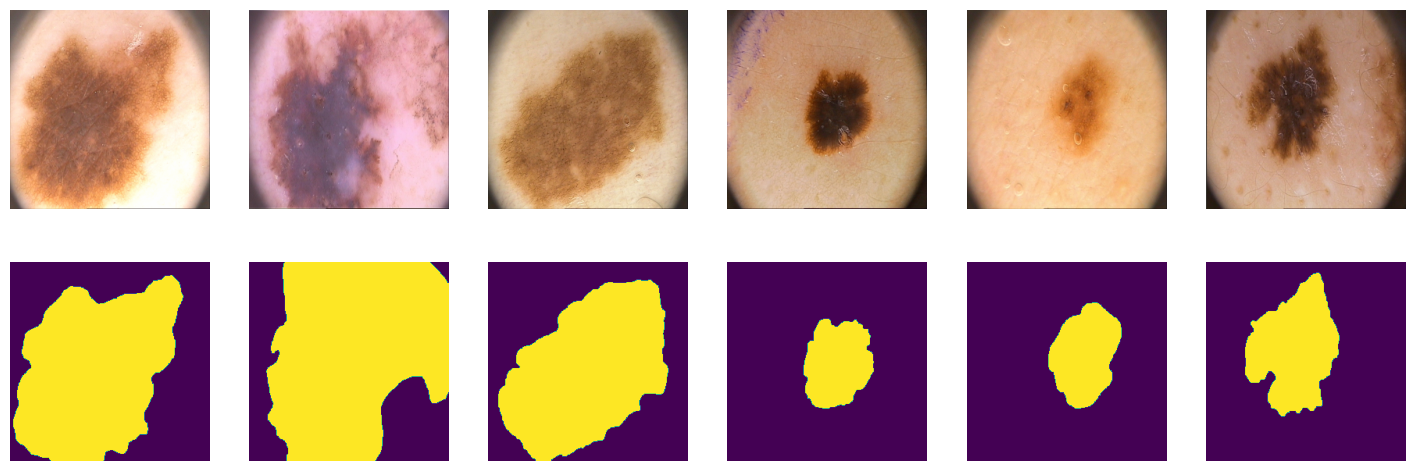

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [6]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [7]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [8]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

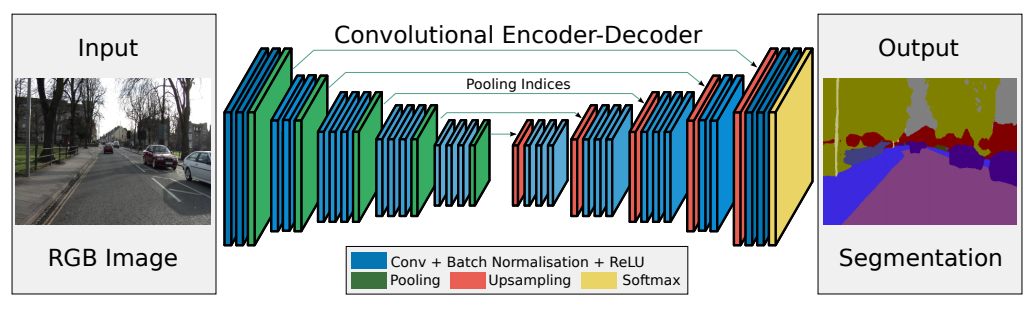

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [11]:
def create_enc_conv_layer2(input_ch,output_ch,size_kernal=3, padding=1):
  return nn.Sequential(
            nn.Conv2d(in_channels = input_ch, out_channels = output_ch, kernel_size=size_kernal, padding=padding),
            nn.BatchNorm2d(output_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels = output_ch, out_channels = output_ch, kernel_size=size_kernal, padding=padding),
            nn.BatchNorm2d(output_ch),
            nn.ReLU()
        )

In [12]:
def create_enc_conv_layer3(input_ch,output_ch,size_kernal=3, padding=1):
  return nn.Sequential(
            nn.Conv2d(in_channels = input_ch, out_channels = output_ch, kernel_size=size_kernal, padding=padding),
            nn.BatchNorm2d(output_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels = output_ch, out_channels = output_ch, kernel_size=size_kernal, padding=padding),
            nn.BatchNorm2d(output_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels = output_ch, out_channels = output_ch, kernel_size=size_kernal, padding=padding),
            nn.BatchNorm2d(output_ch),
            nn.ReLU()
        )

In [13]:
def create_enc_conv_layer2_out(input_ch,output_ch,size_kernal=3, padding=1):
  return nn.Sequential(
            nn.Conv2d(in_channels = input_ch, out_channels = input_ch, kernel_size=size_kernal, padding=padding),
            nn.BatchNorm2d(input_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels = input_ch, out_channels = output_ch, kernel_size=size_kernal, padding=padding),
            nn.BatchNorm2d(output_ch),
            nn.ReLU()
        )
def create_enc_conv_layer3_out(input_ch,output_ch,size_kernal=3, padding=1):
  return nn.Sequential(
            nn.Conv2d(in_channels = input_ch, out_channels = input_ch, kernel_size=size_kernal, padding=padding),
            nn.BatchNorm2d(input_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels = input_ch, out_channels = input_ch, kernel_size=size_kernal, padding=padding),
            nn.BatchNorm2d(input_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels = input_ch, out_channels = output_ch, kernel_size=size_kernal, padding=padding),
            nn.BatchNorm2d(output_ch),
            nn.ReLU()
        )

In [14]:
# (size-kernel+2*padding)/stride + 1 conv2d
# (size - window)/stride+1 polling
first = (256-3+2)/1+1
second = (first - 2)/2+1
print(first,second)

256.0 128.0


In [15]:

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )


        self.enc_conv0 =create_enc_conv_layer2(3,64)
        self.pool0 = nn.MaxPool2d(2,2, return_indices=True) # 256 -> 128
        self.enc_conv1 =create_enc_conv_layer2(64,128)
        self.pool1 = nn.MaxPool2d(2,2, return_indices=True) # 128 -> 64
        self.enc_conv2 =create_enc_conv_layer3(128,256)
        self.pool2 = nn.MaxPool2d(2,2, return_indices=True) # 64 -> 32
        self.enc_conv3 =create_enc_conv_layer3(256,512)
        self.pool3 =nn.MaxPool2d(2,2, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv0 =create_enc_conv_layer3(512,512)
        self.bottleneck_pooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.bottleneck_unpooling = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.bottleneck_conv1 =create_enc_conv_layer3(512,512)

        # decoder (upsampling)
        self.upsample0 =nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 =create_enc_conv_layer3_out(512,256)
        self.upsample1 =nn.MaxUnpool2d(kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 =create_enc_conv_layer3_out(256,128)
        self.upsample2 =nn.MaxUnpool2d(kernel_size=2, stride=2)   # 64 -> 128
        self.dec_conv2 =create_enc_conv_layer2_out(128,64)
        self.upsample3 =nn.MaxUnpool2d(kernel_size=2, stride=2)   # 128 -> 256
        self.dec_conv3 =nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels=1, kernel_size=3, padding=1),
            # nn.BatchNorm2d(1) плохая практика юзать batch norm перед logits
        )


    def forward(self, x):
        # encoder
        e0, pool0 = self.pool0(self.enc_conv0(x))
        e1, pool1 = self.pool1(self.enc_conv1(e0))
        e2, pool2 = self.pool2(self.enc_conv2(e1))
        e3, pool3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b0 =self.bottleneck_conv0(e3)
        b1, bpool = self.bottleneck_pooling(b0)
        b2 = self.bottleneck_unpooling(b1,bpool)
        b3 =self.bottleneck_conv1(b2)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b3,pool3))
        d1 = self.dec_conv1(self.upsample1(d0,pool2))
        d2 = self.dec_conv2(self.upsample2(d1,pool1))
        d3 = self.dec_conv3(self.upsample3(d2,pool0))
         # no activation
        return d3

In [16]:
# !pip install torch-summary

In [17]:
# from torchsummary import summary
# print(summary(SegNet(), (3, 256, 256)))

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [18]:
import gc
gc.collect()

0

In [19]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #




## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [20]:
def bce_loss(y_real, y_pred):
    # TODO
    # please don't use nn.BCELoss. write it from scratch
    loss = torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred*y_real + torch.log(1+torch.exp(-torch.abs(y_pred)))
    return loss.mean((1,2,3)).mean()



In [21]:
def avg_val_test_loss(model, loss_fn, data):
    model.eval()  # testing mode
    loss = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device)).to('cpu')
            loss += loss_fn(Y_pred, Y_label).mean().item()
            del Y_pred

    return loss/len(data)

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [22]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    iou_val=[]
    iou_train=[]
    loss_train_list =[]
    loss_val_list =[]
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch,Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights
            loss = loss.detach().cpu().numpy()
            
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        loss_train_list.append(avg_loss)
        print('loss: %f' % avg_loss)

        # show intermediate results
        with torch.no_grad():
            model.eval()  # testing mode
            Y_hat = model(X_val.to(device)).detach().to("cpu") # detach and put into cpu
            loss_val = avg_val_test_loss(model,loss_fn,data_val)
            print('loss_val: %f' % loss_val)
            loss_val_list.append(loss_val)
            iou_v = score_model(model, iou_pytorch, data_val)
            iou_t = score_model(model, iou_pytorch, data_tr)
            iou_val.append(iou_v)
            iou_train.append(iou_t)
        print('iou_v: %f' % iou_v)
        print('iou_t: %f' % iou_t)
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return (iou_val,iou_train, loss_val_list,loss_train_list)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [23]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [24]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = torch.sigmoid(model(X_batch.to(device))) > 0.5
            Y_pred = Y_pred.to('cpu')
            scores += metric(Y_pred, Y_label).mean().item()
            del Y_pred

    return scores/len(data)

In [25]:
def score_all(model, metric):
    tr = score_model(model, iou_pytorch, data_tr)
    val = score_model(model, iou_pytorch, data_val)
    ts = score_model(model, iou_pytorch, data_ts)
    print(f"train iou {tr}")
    print(f"val iou {val}")
    print(f"test iou {ts}")    
    return (tr, val, ts)

In [26]:
import matplotlib.pyplot as plt

def plot_val_train(data,name,loss_name):
    epochs = [i for i in range(len(data[name][0]))]
    fig, ax = plt.subplots(1, 2, figsize = (14, 7))
    iou_val =data[name][0]
    iou_train =data[name][1]
    loss_val_list =data[name][2]
    loss_train_list =data[name][3]
    ax[0].plot(epochs, iou_train, label='Train', marker='x')
    ax[0].plot(epochs, iou_val, label='Val', marker='x')

    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('iou')
    ax[0].set_title('metric')
    ax[1].plot(epochs, loss_train_list, label='Train', marker='x')
    ax[1].plot(epochs, loss_val_list, label='Val', marker='x')

    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('loss')
    ax[1].set_title(loss_name)
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [27]:
# torch.cuda.empty_cache()
result = dict()

In [28]:
model = SegNet().to(device)

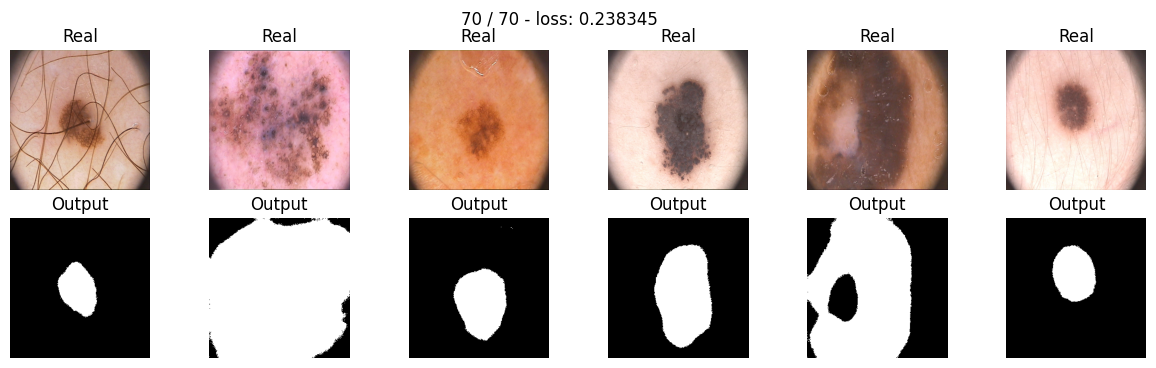

In [29]:
max_epochs = 70
optim = torch.optim.AdamW(model.parameters(), lr=1e-5, betas=(0.8, 0.899), eps=1e-08, weight_decay=0.01, amsgrad=True)
result['seg_bce'] = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [30]:
result["seg_bce_r"]= score_all(model, iou_pytorch)

train iou 0.8889999538660049
val iou 0.6740000247955322
test iou 0.5559999942779541


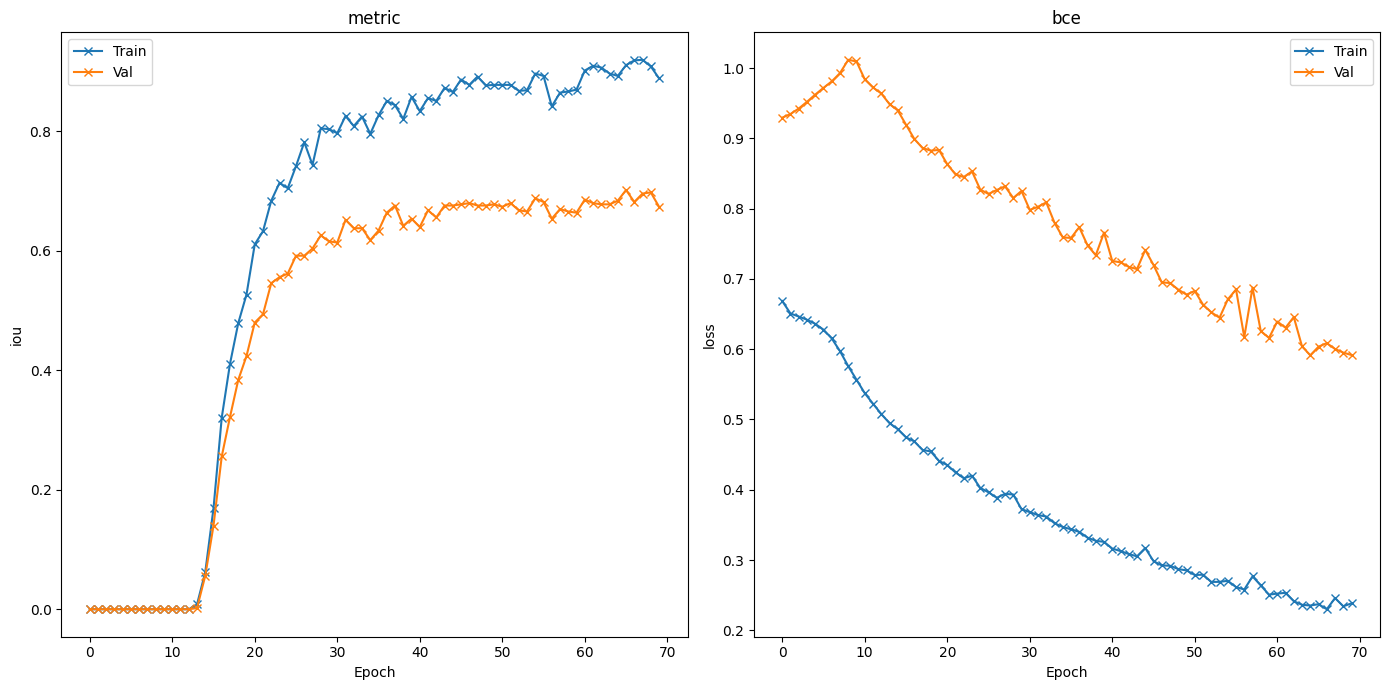

In [31]:
plot_val_train(result,'seg_bce','bce')

In [33]:
import gc
model = None 
optim = None
torch.cuda.empty_cache()
gc.collect()

61503

Ответьте себе на вопрос: не переобучается ли моя модель?

по графику видно что да, потому что валидация не падала, но с другой стороны после 35 эпохи перестала обучаться

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [35]:
def dice_loss(y_real,y_pred, smooth=1):
    y_pred = torch.sigmoid(y_pred)
    num = (2*y_pred*y_real).sum((1,2,3)) + smooth
    den = (y_pred + y_real).sum((1,2,3)) + smooth
    res = 1 - (num/den).mean()
    return res



Проводим тестирование:

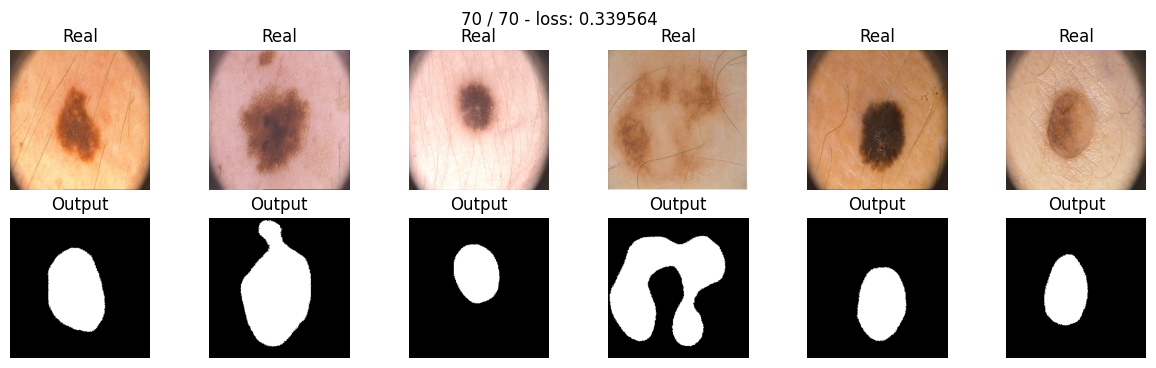

In [36]:
model = SegNet().to(device)

max_epochs = 70
optim = torch.optim.AdamW(model.parameters(), lr=1e-5, betas=(0.8, 0.899), eps=1e-08, weight_decay=0.01, amsgrad=True)
result['seg_dice'] = train(model, optim, dice_loss, max_epochs, data_tr, data_val)

In [37]:
result["seg_dice_r"]= score_all(model, iou_pytorch)

train iou 0.8950000107288361
val iou 0.6699999868869781
test iou 0.5900000035762787


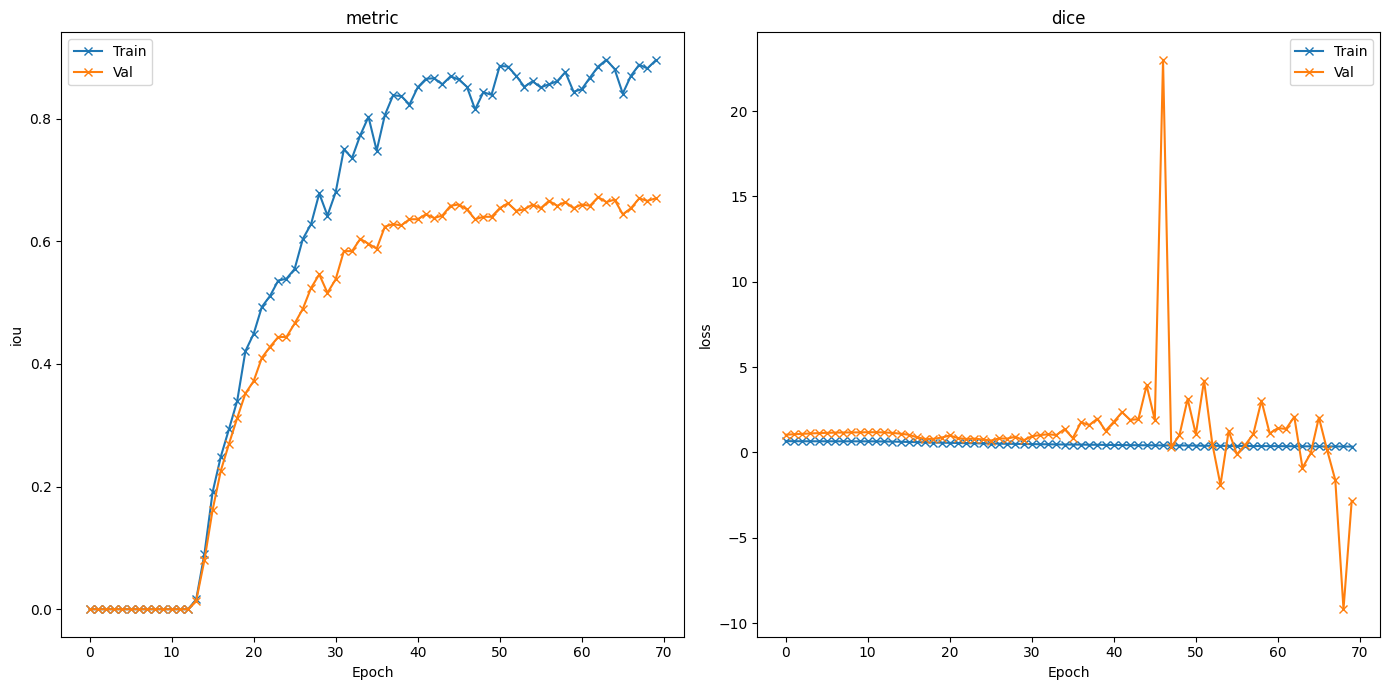

In [38]:
plot_val_train(result,'seg_dice','dice')

In [39]:
import gc
model = None 
optim = None
torch.cuda.empty_cache()
gc.collect()

114895

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [40]:
def focal_loss(y_real, y_pred, eps = 0.25, gamma = 2):
    p = torch.sigmoid(y_pred)
    ce_loss = torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred*y_real + torch.log(1+torch.exp(-torch.abs(y_pred)))
    p_t = p * y_real + (1 - p) * (1 - y_real)
    loss = ce_loss * ((1 - p_t) ** gamma)
    if eps >= 0:
        alpha_t = eps * y_real + (1 - eps) * (1 - y_real)
        loss = alpha_t * loss
    return loss.mean((1,2,3)).mean()


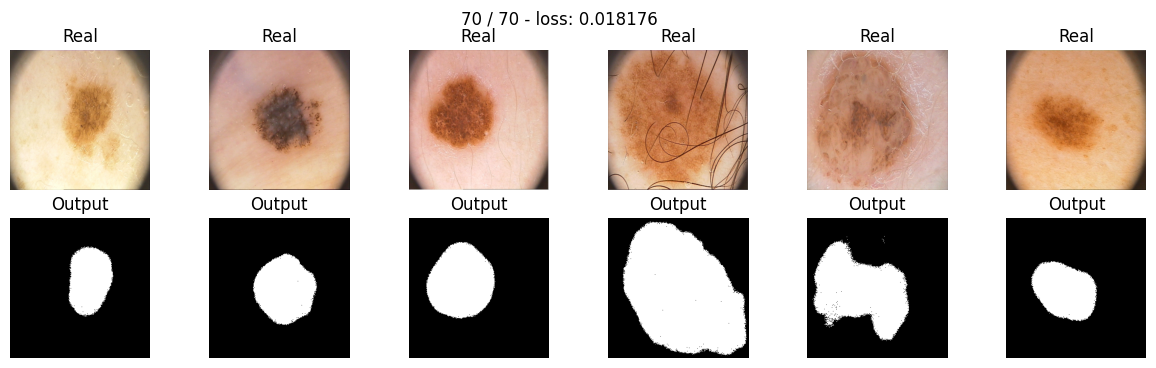

In [41]:
model = SegNet().to(device)

max_epochs = 70
optim = torch.optim.AdamW(model.parameters(), lr=1e-5, betas=(0.8, 0.899), eps=1e-08, weight_decay=0.01, amsgrad=True)
result['seg_focal']  = train(model, optim, focal_loss, max_epochs, data_tr, data_val)

In [42]:
result["seg_focal_r"]= score_all(model, iou_pytorch)

train iou 0.8989999890327454
val iou 0.6499999761581421
test iou 0.6019999980926514


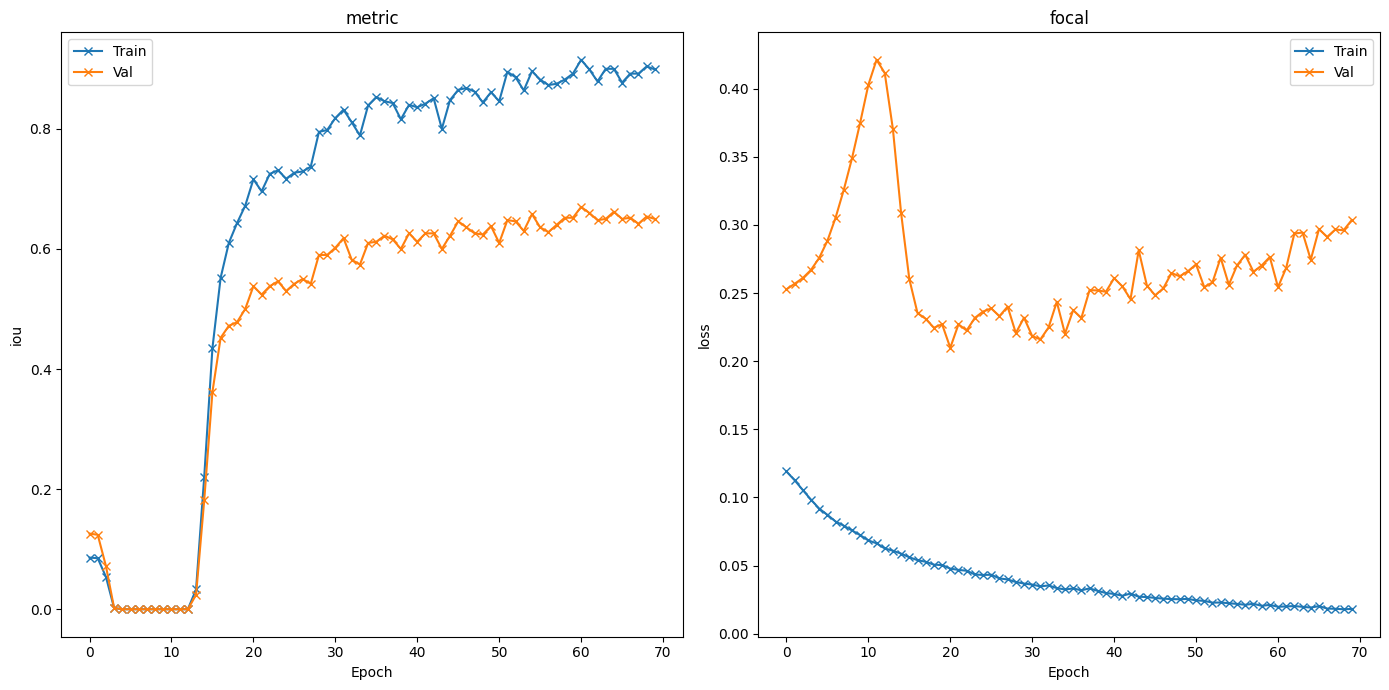

In [43]:
plot_val_train(result,'seg_focal','focal')

In [44]:
import gc
model = None 
optim = None
torch.cuda.empty_cache()
gc.collect()

61454

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [45]:
def tversky_loss(y_real, y_pred, alpha=0.3, beta=0.7):
    y_pred = nn.Flatten()(y_pred.sigmoid())
    y_real = nn.Flatten()(y_real)

    TP = torch.sum(y_pred * y_real)
    FP = torch.sum((1 - y_real) * y_pred)
    FN = torch.sum(y_real * (1 - y_pred))

    return 1 - TP / ((TP + alpha * FP + beta * FN) or 1)  


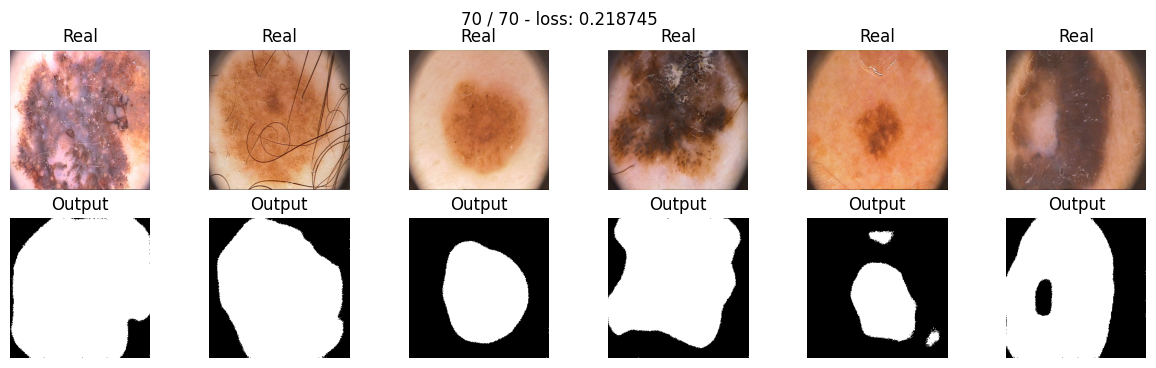

In [46]:
model = SegNet().to(device)

max_epochs = 70
optim = torch.optim.AdamW(model.parameters(), lr=1e-5, betas=(0.8, 0.899), eps=1e-08, weight_decay=0.01, amsgrad=True)
result['seg_tversky'] = train(model, optim, tversky_loss, max_epochs, data_tr, data_val)

In [47]:
result["seg_tversky_r"]= score_all(model, iou_pytorch)

train iou 0.7920000106096268
val iou 0.6199999749660492
test iou 0.5219999998807907


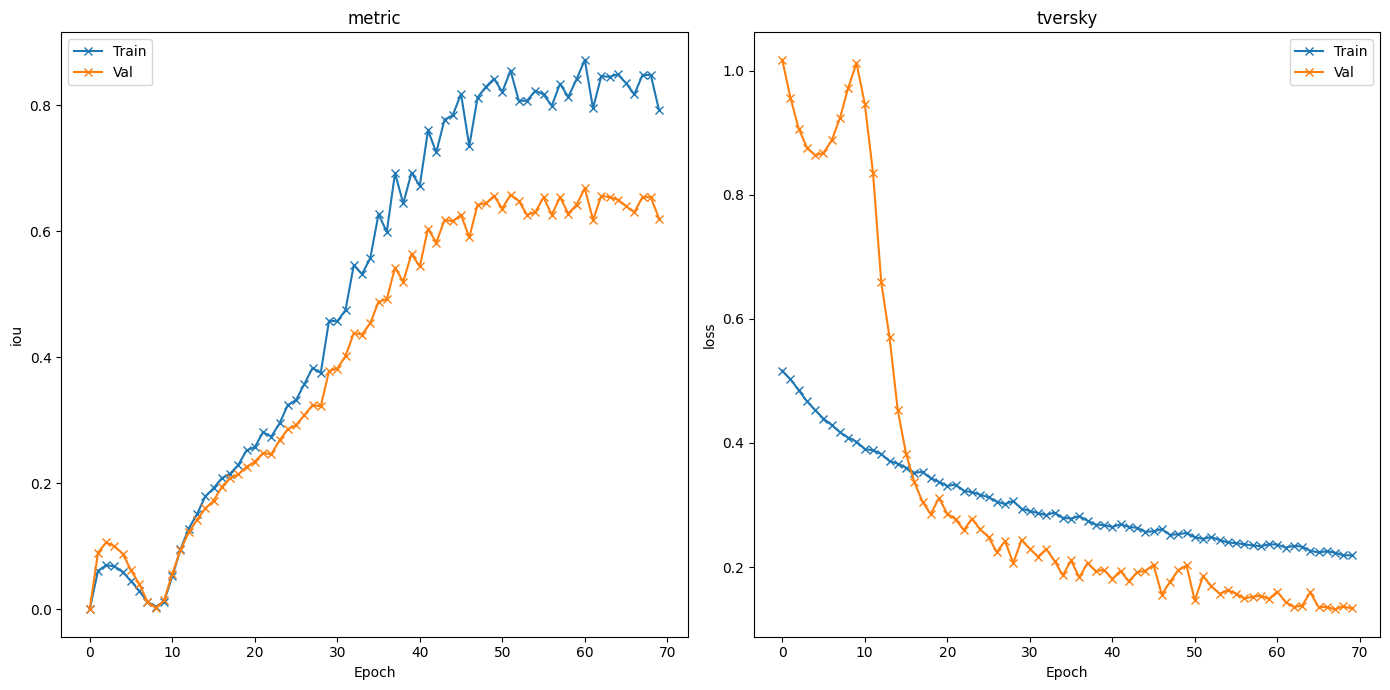

In [48]:
plot_val_train(result,'seg_tversky','tversky')

In [49]:
import gc
model = None 
optim = None
torch.cuda.empty_cache()
gc.collect()

61095

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

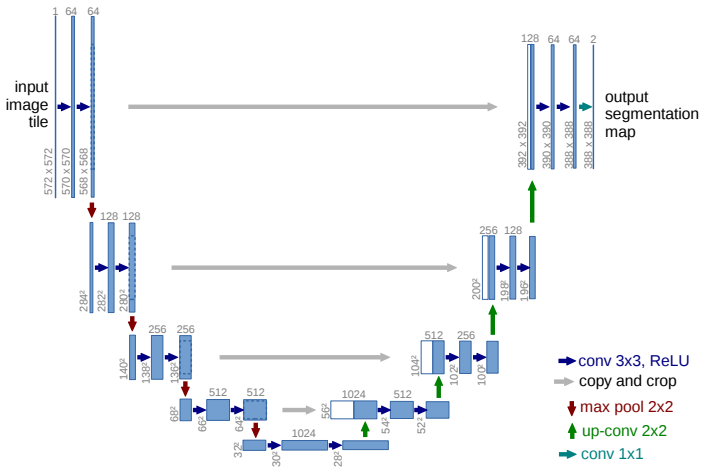

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [50]:
def create_enc_conv_layer2_unet_out(input_ch,output_ch,size_kernal=3, padding=1):
    mid_ch = input_ch//2
    return nn.Sequential(
            nn.Conv2d(in_channels = input_ch, out_channels = mid_ch, kernel_size=size_kernal, padding=padding),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels = mid_ch, out_channels = output_ch, kernel_size=size_kernal, padding=padding),
            nn.BatchNorm2d(output_ch),
            nn.ReLU()
        )

In [51]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 =create_enc_conv_layer2(3,64)
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 =create_enc_conv_layer2(64,128)
        self.pool1 = nn.MaxPool2d(2, 2) # 128 -> 64
        self.enc_conv2 =create_enc_conv_layer2(128,256)
        self.pool2 = nn.MaxPool2d(2, 2) # 64 -> 32
        self.enc_conv3 =create_enc_conv_layer2(256,512)
        self.pool3 = nn.MaxPool2d(2, 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 16 -> 32
        self.dec_conv0 = create_enc_conv_layer2_unet_out(1024,256)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 32 -> 64
        self.dec_conv1 = create_enc_conv_layer2_unet_out(512,128)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 64 -> 128
        self.dec_conv2 = create_enc_conv_layer2_unet_out(256,64)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 128 -> 256
        self.dec_conv3 =nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels=1, kernel_size=3, padding=1),
            # nn.BatchNorm2d(1) плохая практика юзать batch norm перед logits
        )

    def forward(self, x):
        # encoder
        e0 =self.pool0(self.enc_conv0(x))
        e1 =self.pool1(self.enc_conv1(e0))
        e2 =self.pool2(self.enc_conv2(e1))
        e3 =self.pool3(self.enc_conv3(e2))

        # bottleneck
        b =self.bottleneck_conv(e3)
#         print(b.shape)
#         print(e3.shape)
        # decoder
        d0 =self.dec_conv0(self.upsample0(torch.cat([b,e3],1)))
        d1 =self.dec_conv1(self.upsample1(torch.cat([d0,e2],1)))
        d2 =self.dec_conv2(self.upsample2(torch.cat([d1,e1],1)))
        d3 =self.dec_conv3(self.upsample3(torch.cat([d2,e0],1)))  # no activation
        return d3

In [52]:
unet_model = UNet().to(device)

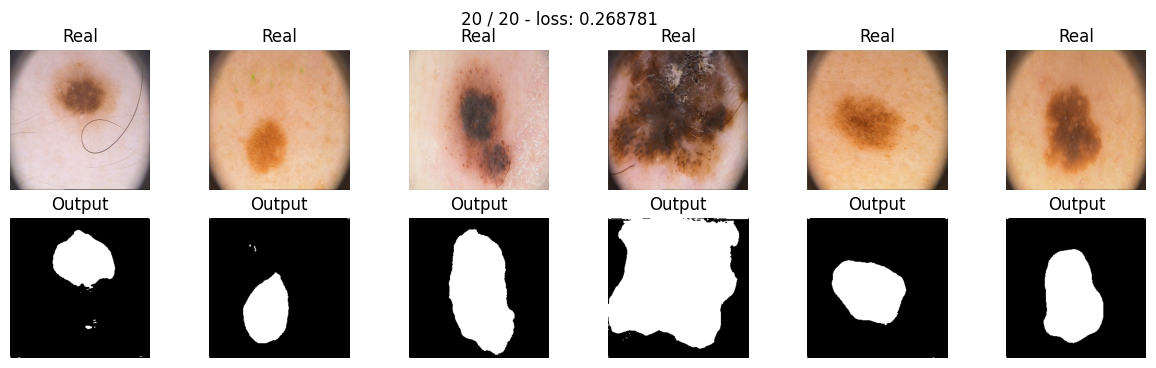

In [53]:
max_epochs = 20
optim = torch.optim.AdamW(unet_model.parameters(), lr=1e-5, betas=(0.8, 0.899), eps=1e-08, weight_decay=0.01, amsgrad=True)
result['unet_bce'] = train(unet_model, optim, bce_loss, max_epochs, data_tr, data_val)

In [54]:
result["unet_bce_r"]= score_all(unet_model, iou_pytorch)

train iou 0.8920000046491623
val iou 0.7160000205039978
test iou 0.664000004529953


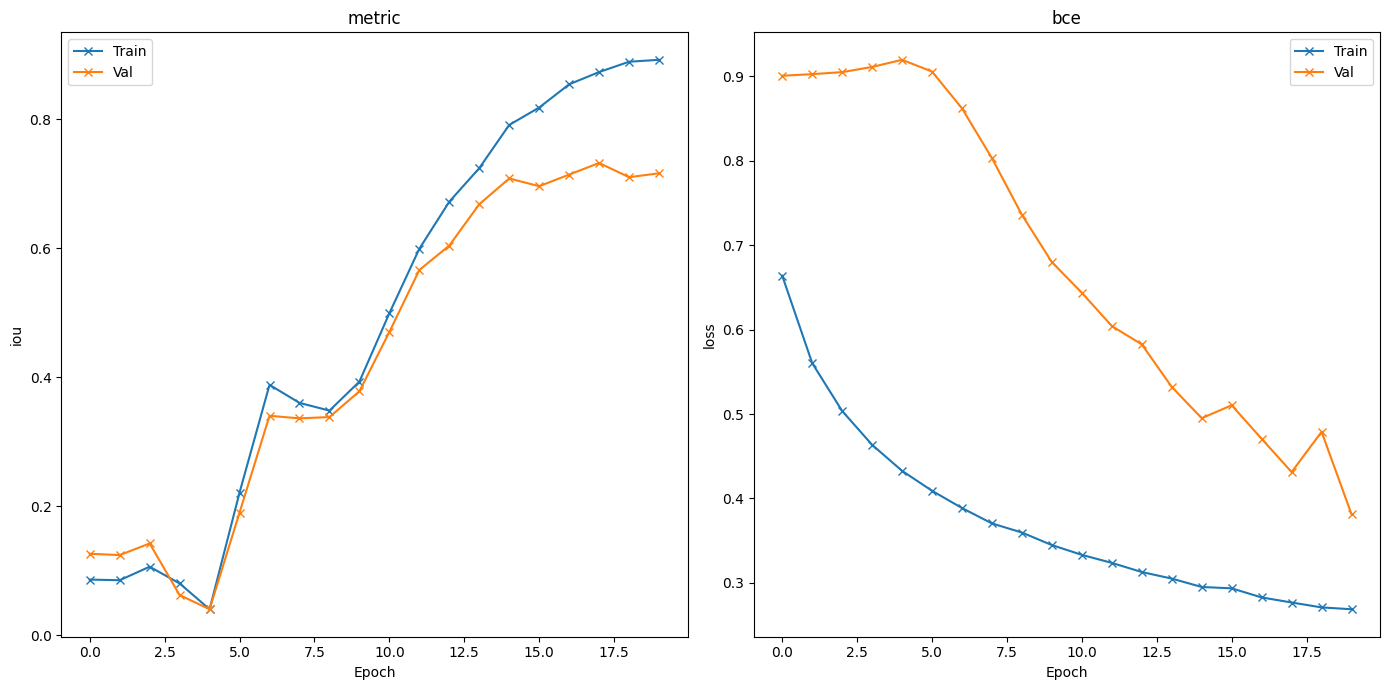

In [55]:
plot_val_train(result,'unet_bce','bce')

In [56]:
import gc
unet_model = None 
optim = None
torch.cuda.empty_cache()
gc.collect()

61341

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [57]:
(256-2)/2 + 1

128.0

In [58]:
((16-1)*2-2*0+1*(2-1))+1

32

In [59]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 =create_enc_conv_layer2(3,64)
        self.conv0 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 =create_enc_conv_layer2(64,128)
        self.conv1 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 =create_enc_conv_layer2(128,256)
        self.conv2 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 =create_enc_conv_layer2(256,512)
        self.conv3 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.conv_trans0 = nn.ConvTranspose2d(1024,1024,2,2) # 16 -> 32
        self.dec_conv0 = create_enc_conv_layer2_unet_out(1024,256)
        self.conv_trans1 = nn.ConvTranspose2d(512,512,2,2) # 32 -> 64
        self.dec_conv1 = create_enc_conv_layer2_unet_out(512,128)
        self.conv_trans2 = nn.ConvTranspose2d(256,256,2,2)  # 64 -> 128
        self.dec_conv2 = create_enc_conv_layer2_unet_out(256,64)
        self.conv_trans3 = nn.ConvTranspose2d(128,128,2,2)  # 128 -> 256
        self.dec_conv3 =nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels=1, kernel_size=3, padding=1),
            # nn.BatchNorm2d(1) плохая практика юзать batch norm перед logits
        )

    def forward(self, x):
        # encoder
        e0 =self.conv0(self.enc_conv0(x))
        e1 =self.conv1(self.enc_conv1(e0))
        e2 =self.conv2(self.enc_conv2(e1))
        e3 =self.conv3(self.enc_conv3(e2))

        # bottleneck
        b =self.bottleneck_conv(e3)
#         print(b.shape)
#         print(e3.shape)
        # decoder
        d0 =self.dec_conv0(self.conv_trans0(torch.cat([b,e3],1)))
        d1 =self.dec_conv1(self.conv_trans1(torch.cat([d0,e2],1)))
        d2 =self.dec_conv2(self.conv_trans2(torch.cat([d1,e1],1)))
        d3 =self.dec_conv3(self.conv_trans3(torch.cat([d2,e0],1)))  # no activation
        return d3


In [60]:
unet2_model = UNet2().to(device)


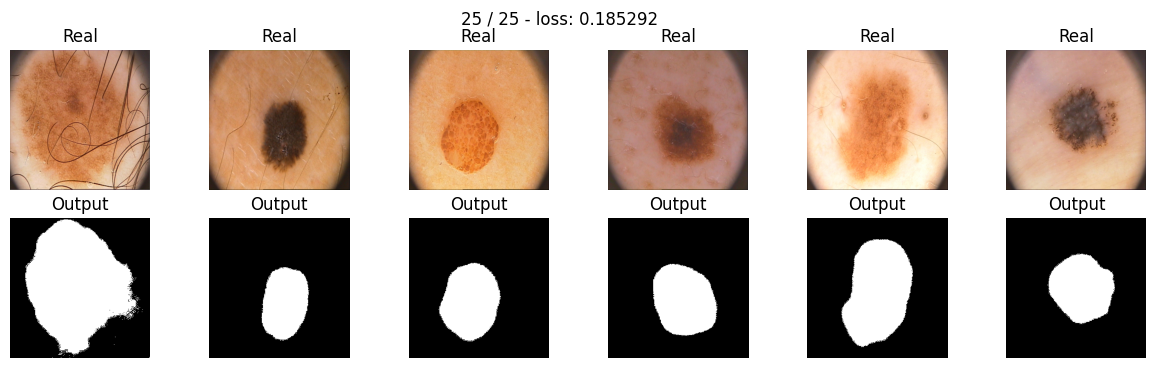

In [61]:
max_epochs = 25
optim = torch.optim.AdamW(unet2_model.parameters(), lr=1e-5, betas=(0.8, 0.899), eps=1e-08, weight_decay=0.01, amsgrad=True)
result['unet2_bce'] = train(unet2_model, optim, bce_loss, max_epochs, data_tr, data_val)

In [62]:
result["unet2_bce_r"]= score_all(unet2_model, iou_pytorch)

train iou 0.8959999531507492
val iou 0.69200000166893
test iou 0.6780000030994415


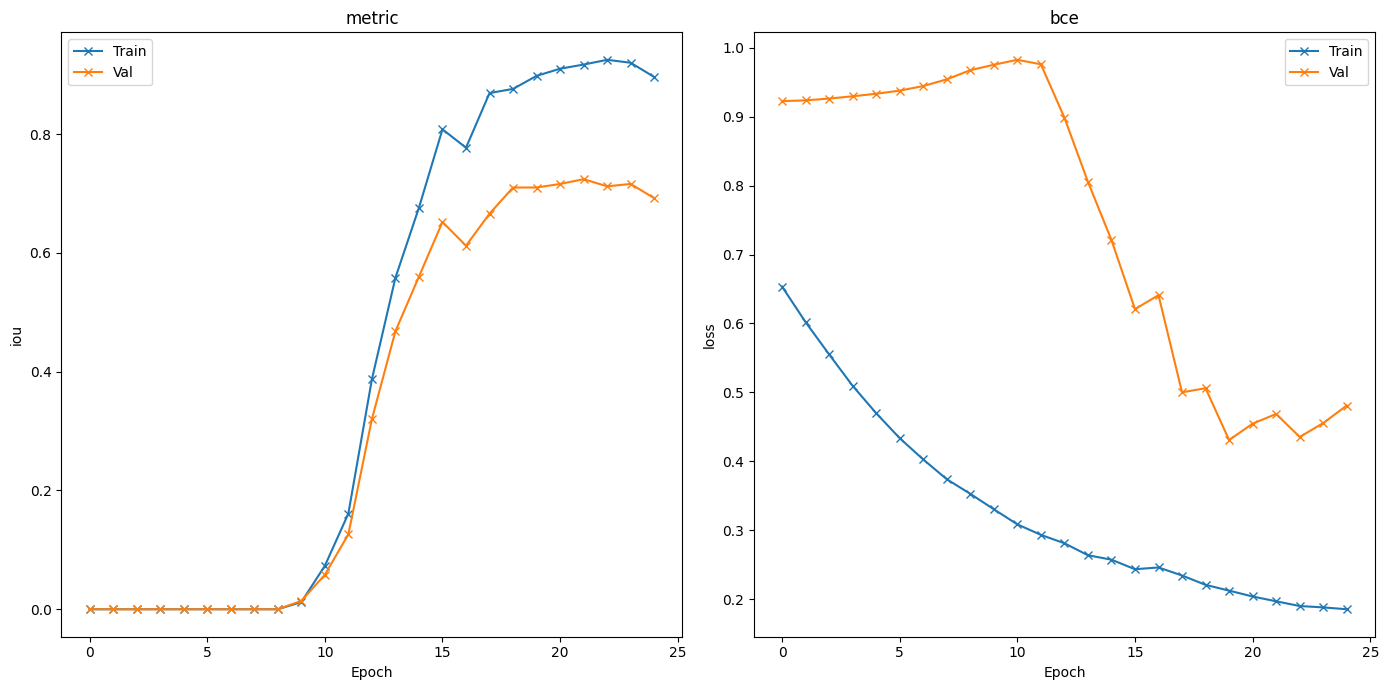

In [63]:
plot_val_train(result,'unet2_bce','bce')

In [64]:
import gc
unet2_model = None 
optim = None
torch.cuda.empty_cache()
gc.collect()

87882

In [67]:
len(result.keys())

12

In [71]:
names = [i for i in result.keys() if i[-2:] == '_r']
ts_score = [result[i][2] for i in names]

['seg_bce_r',
 'seg_dice_r',
 'seg_focal_r',
 'seg_tversky_r',
 'unet_bce_r',
 'unet2_bce_r']

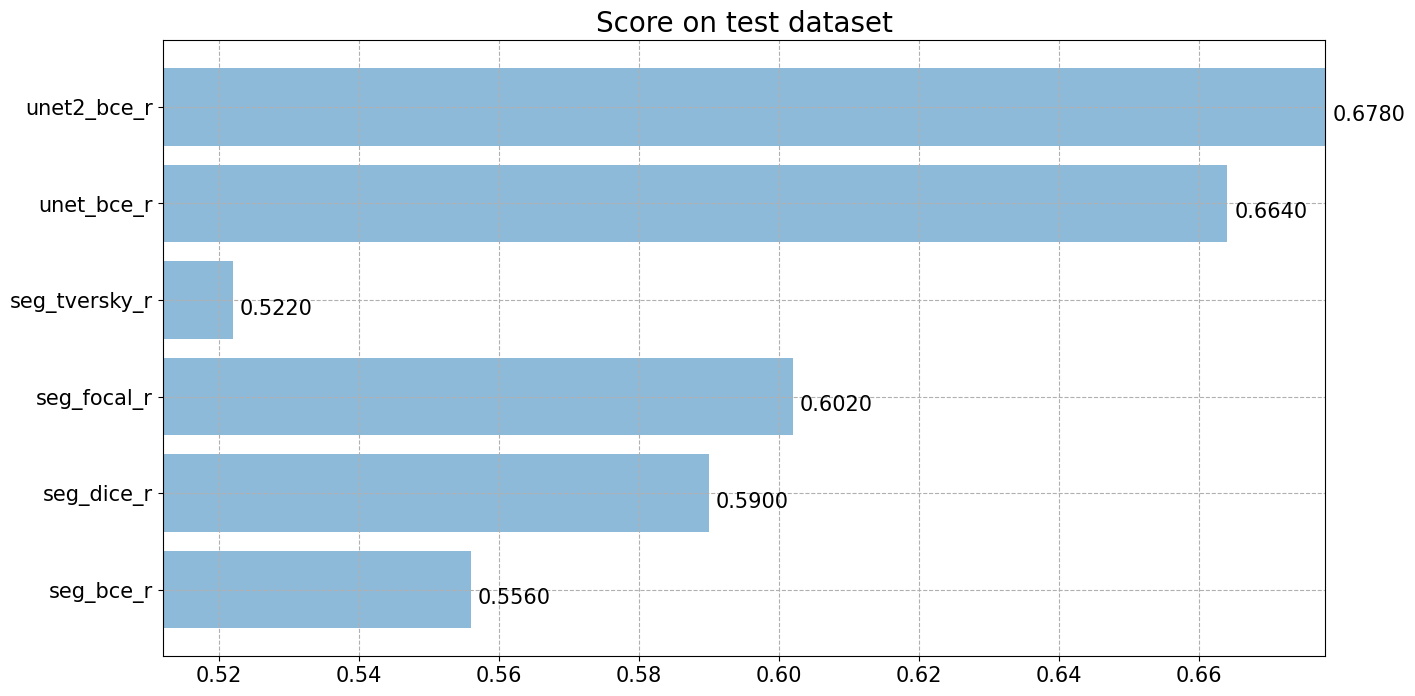

In [76]:
fig, ax = plt.subplots(figsize = (15, 8))
ax.barh(names, ts_score, alpha = 0.5)
ax.set_xlim(min(ts_score)-0.01, max(ts_score))
ax.tick_params(labelsize = 15)
for i in range(6):
    ax.text(ts_score[i]+0.001, i - 0.15, f"{ts_score[i]:.4f}", fontsize = 15)
    ax.grid(linestyle="--")
ax.set_title("Score on test dataset", fontsize = 20)
plt.show()

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

По результата можно увидеть фаворита 
Unet2 , нужно было конечно потестить с другими loss,
это не совсем репрезентативный результат из-за разных начальных весов(random)
просто устал делать эту таску 